In [1]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# 日本語フォントを設定
font = {'family': 'IPAexGothic'}
mpl.rc('font', **font)

%matplotlib inline

In [75]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [76]:
%autoreload 2

In [46]:
from dataset.read_dataset import read_whas100_df


whas100_df = read_whas100_df()
whas100_df.head()

,登録日(観察開始日),追跡日(観察終了日),入院期間,追跡日数(観察日数),生存状態,登録時年齢,性別,BMI
1,03/13/1995,03/19/1995,4,6,1,65,0,31.38134
2,01/14/1995,01/23/1996,5,374,1,88,1,22.65790
3,02/17/1995,10/04/2001,5,2421,1,77,0,27.87892
4,04/07/1995,07/14/1995,9,98,1,81,1,21.47878
5,02/09/1995,05/29/1998,4,1205,1,78,0,30.70601


上のデータセットは、急性心筋梗塞にともなう入院後の生存時間データである。このデータを用いて、急性心筋梗塞にともなう入院からの生存時間に対して、性別、年齢、入院時のBMIが与える影響を調べる。

In [47]:
d = (whas100_df['生存状態'] == 1).sum()
c = (whas100_df['生存状態'] != 1).sum()
print('死亡者数 = %d' % d)
print('打切り者数 = %d' % c)

死亡者数 = 51
打切り者数 = 49


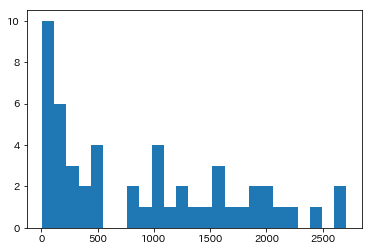

In [48]:
# plt.hist(y['Survival_in_days'], bins=100)
plt.hist(whas100_df[whas100_df['生存状態'] == 1]['追跡日数(観察日数)'].values, bins=25)
plt.show()

In [49]:
dataset_df = whas100_df.copy()

---
# 生存関数の推定
## Kaplan-Meier推定量
> 生存時間データから**生存関数**を推定するために使用されるノンパラメトリック統計量.
>
> - $d_{j}$: 時刻$t_{(j)}$でのイベント発生者数
> - $n_{j}$: 時刻$t_{(j)}$でイベント発生のリスク集合にいる人数
>     - 打切りデータは、打切りが記録された時間でのリスク集合にいる人数に含めるが、その時点よりすぐ後のリスク集合にいる人数には含めない
> - イベントが観測された時刻を小さい順に$t_{(1)} \le t_{(2)} \le \cdots \le t_{(k)}$とする

$$
\widehat {S}\left(t\right) = \prod _{ j=1 }^{ k }{ \left( \frac {n_{j} - d_{j}}{n_{j}} \right) }
$$

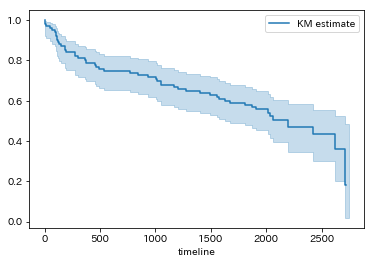

In [50]:
from lifelines import KaplanMeierFitter


survival_time_col = '追跡日数(観察日数)'
event_col              = '生存状態'
survival_times      = dataset_df[survival_time_col]
events                    = dataset_df[event_col]

# fitting
kmf = KaplanMeierFitter()
kmf.fit(survival_times, event_observed=events, label='KM estimate')

# plot
plt.figure(figsize=(15, 8))
kmf.plot(ci_show=True)
plt.show()

In [52]:
whas100_df['生存状態'].replace({1: True, 0: False}, inplace=True)

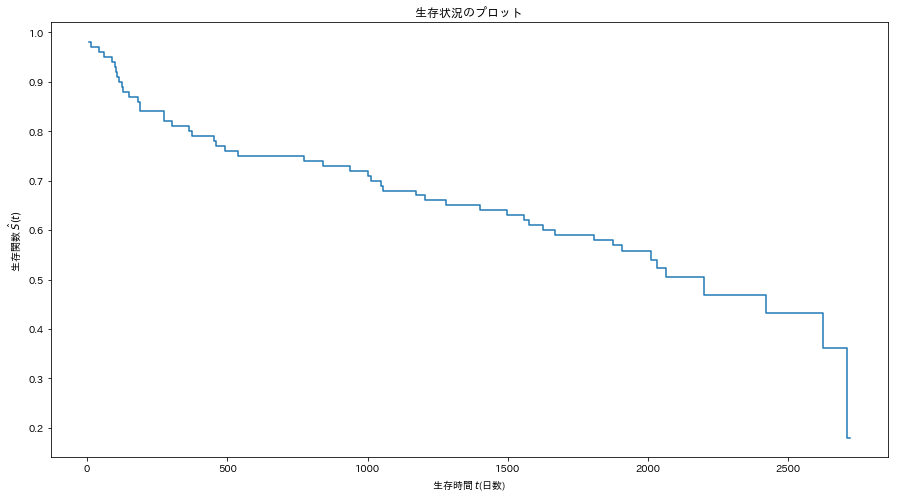

In [83]:
from sksurv.nonparametric import kaplan_meier_estimator


survival_bools = whas100_df['生存状態'].values
survival_times = whas100_df['追跡日数(観察日数)'].values

time, survival_prob = kaplan_meier_estimator(survival_bools, survival_times)

plt.figure(figsize=(15, 8))
plt.title('生存状況のプロット')
plt.step(time, survival_prob, where="post")
plt.ylabel("生存関数 $\hat{S}(t)$")
plt.xlabel("生存時間 $t$(日数)")
plt.show()

In [80]:
from src.nonparametric import _calc_kaplan_meier_variance

time, var = _calc_kaplan_meier_variance(survival_bools, survival_times)

In [84]:
print(time.shape)
print(var.shape)

(95,)
(95,)


# 累積ハザード関数の推定

## Nelson-Aalen推定量
> 不完全なデータや打切りデータの場合の**累積ハザード関数**を推定するための使用されるノンパラメトリック推定量。
>
> - $d_{i}$: 時刻$t_{i}$でのイベント発生者数
> - $n_{i}$: 時刻$T_{i}$の直前で生存している被験者数
>
> $$
\widehat {H}\left(t\right) = \sum _{t_{i} \le t}{ \frac {d_{i}}{n_{i}} }
$$

# ハザード関数の推定